## Next Step: Use whole training set for text_clf, dont check valid

In [28]:
def load_data():
    """Loads data from hardcoded directory"""
    train = pd.read_csv("~/projects/fundamentals-of-ml/kaggle/arxiv_classification/data/train.csv")
    test = pd.read_csv("~/projects/fundamentals-of-ml/kaggle/arxiv_classification/data/test.csv")
    return train, test

def split_training_set(df, ratio=0.70):
    """Splits training set into train and validation at a ratio of 70/30"""
    df.sample(frac=1)
    train = df[:int(ratio*df.shape[0])]
    validation = df[int(ratio*df.shape[0]):]
    return train, validation

In [29]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

In [30]:
# Processed data
# train = pd.read_csv("data/processed_train.csv")
# test = pd.read_csv("data/processed_test.csv")
train, test = load_data()
train, valid = split_training_set(train)

In [31]:
mystopwords = []

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(list(stopwords.words('english')) + list(mystopwords))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

In [32]:
# %%time
train['Abstract'] = train['Abstract'].apply(clean_text)
test['Abstract'] = test['Abstract'].apply(clean_text)
valid['Abstract'] = valid['Abstract'].apply(clean_text)

In [33]:
# Extracting features from text files
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train['Abstract'])
X_train_counts.shape

# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(5250, 71187)

In [34]:
# Machine Learning
# Training Naive Bayes (NB) classifier on training data.
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, train['Category'])

In [35]:
# Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
# The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
# We will be using the 'text_clf' going forward.
from sklearn.pipeline import Pipeline

# for a in [0.01, 0.05, 0.1, 0.15, 0.3, 0.5, 1]: # 0.15 then 0.3
text_clf = Pipeline([('vect', CountVectorizer()), 
                     ('tfidf', TfidfTransformer()), 
                     ('clf', MultinomialNB(alpha=0.15))])
text_clf = text_clf.fit(train['Abstract'], train['Category'])

## Performance of NB Classifier
import numpy as np
predicted = text_clf.predict(valid['Abstract'])
print(np.mean(predicted == valid['Category']))

0.7715555555555556


In [36]:
# # Make submission
# predicted = text_clf.predict(test['Abstract'])
# test['Category'] = predicted
# test.drop(columns=['Abstract'], inplace=True)
# test.drop(columns=['Unnamed: 0'], inplace=True)
# test.to_csv("submissions/sklearn_multinomial_nb_alpha03.csv", index=False)

## SVM

In [40]:
# Training Support Vector Machines - SVM and calculating its performance
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

for itera in [5, 10, 20, 50]:
    for a in [0.001, 0.005, 0.0075, 0.01, 0.02]:
        text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                                 ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=a, max_iter=itera, random_state=42))])

        text_clf_svm = text_clf_svm.fit(train['Abstract'], train['Category'])
        predicted_svm = text_clf_svm.predict(valid['Abstract'])
        print(f"{itera}, {a} =>> {np.mean(predicted_svm == valid['Category'])}")

5, 0.001 =>> 0.7435555555555555
5, 0.005 =>> 0.7448888888888889
5, 0.0075 =>> 0.7448888888888889
5, 0.01 =>> 0.744
5, 0.02 =>> 0.7435555555555555
10, 0.001 =>> 0.7448888888888889
10, 0.005 =>> 0.7417777777777778
10, 0.0075 =>> 0.7404444444444445
10, 0.01 =>> 0.7431111111111111
10, 0.02 =>> 0.7413333333333333
20, 0.001 =>> 0.7448888888888889
20, 0.005 =>> 0.7417777777777778
20, 0.0075 =>> 0.7404444444444445
20, 0.01 =>> 0.7431111111111111
20, 0.02 =>> 0.7413333333333333
50, 0.001 =>> 0.7448888888888889
50, 0.005 =>> 0.7417777777777778
50, 0.0075 =>> 0.7404444444444445
50, 0.01 =>> 0.7431111111111111
50, 0.02 =>> 0.7413333333333333


In [47]:
d = {"Max_iter": [5,5,5,5,5,10,10,10,10,10,20,20,20,20,20,50,50,50,50,50],
	"Alpha": [0.001, 0.005, 0.0075, 0.01, 0.02,0.001, 0.005, 0.0075, 0.01, 0.02,0.001, 0.005, 0.0075, 0.01, 0.02, 0.001, 0.005, 0.0075, 0.01, 0.02],
	"Accuracy": [0.7435555555555555, 0.7448888888888889, 0.7448888888888889, 0.744, 0.7435555555555555, 
               0.7448888888888889, 0.7417777777777778, 0.7404444444444445, 0.7431111111111111, 0.7413333333333333, 
               0.7448888888888889, 0.7417777777777778, 0.7404444444444445, 0.7431111111111111, 0.7413333333333333, 
               0.7448888888888889, 0.7417777777777778, 0.7404444444444445, 0.7431111111111111, 0.7413333333333333]
	}
df=pd.DataFrame(data=d)

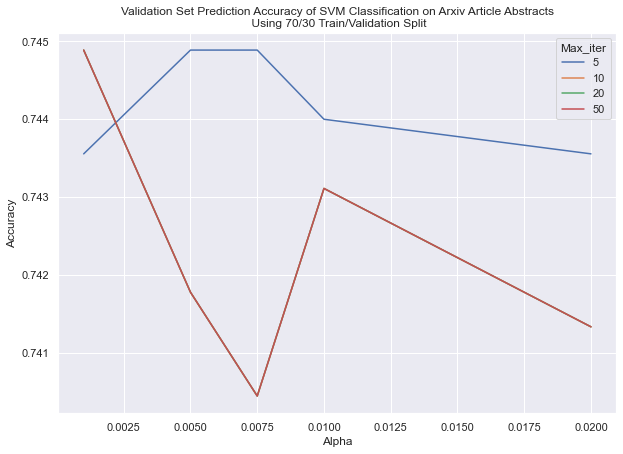

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.figure(figsize=(10, 7))
plt.title('Validation Set Prediction Accuracy of SVM Classification on Arxiv Article Abstracts\n Using 70/30 Train/Validation Split')
sns.lineplot(x="Alpha", y="Accuracy", palette="deep", hue="Max_iter", data=df)
plt.savefig('compareSVM.png')
plt.show();

In [38]:
# Grid Search
# Here, we are creating a list of parameters for which we would like to do performance tuning. 
# All the parameters name start with the classifier name (remember the arbitrary name we gave). 
# E.g. vect__ngram_range; here we are telling to use unigram and bigrams and choose the one which is optimal.

from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (0.5, 0.2, 0.15, 0.1, 1e-2, 1e-3)}

In [19]:
# Next, we create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(train['Abstract'], train['Category'])

In [20]:
# To see the best mean score and the params, run the following code

gs_clf.best_score_
gs_clf.best_params_

# Output for above should be: The accuracy has now increased to ~90.6% for the NB classifier (not so naive anymore! 😄)
# and the corresponding parameters are {‘clf__alpha’: 0.01, ‘tfidf__use_idf’: True, ‘vect__ngram_range’: (1, 2)}.

{'clf__alpha': 0.1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}

In [54]:
# Similarly doing grid search for SVM
from sklearn.model_selection import GridSearchCV
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False),'clf-svm__alpha': (1e-2, 1e-3)}

gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(train['Abstract'], train['Category'])


gs_clf_svm.best_score_
gs_clf_svm.best_params_

/Users/Matteo/miniconda/envs/mila3.7/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


{'clf-svm__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

In [55]:
# # NLTK
# # Removing stop words
# from sklearn.pipeline import Pipeline
# text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer()), 
#                      ('clf', MultinomialNB())])

In [21]:
# # Stemming Code

# import nltk
# #nltk.download()

# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer("english", ignore_stopwords=True)

# class StemmedCountVectorizer(CountVectorizer):
#     def build_analyzer(self):
#         analyzer = super(StemmedCountVectorizer, self).build_analyzer()
#         return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
# stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

# text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect), ('tfidf', TfidfTransformer()), 
#                              ('mnb', MultinomialNB(fit_prior=False))])

# text_mnb_stemmed = text_mnb_stemmed.fit(train['Abstract'], train['Category'])

# predicted_mnb_stemmed = text_mnb_stemmed.predict(valid['Abstract'])

# np.mean(predicted_mnb_stemmed == valid['Category'])

0.7631111111111111